In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# some lib

**Скачайте необходимые данные по ссылке: https://www.kaggle.com/c/house-prices-advanced-regression-techniques**

In [2]:
data = pd.read_csv("train_house.csv", header=0)

✅ Посмотрите, как выглядят данные, и приступайте к анализу

In [3]:
# ничего себе, зачем так много столбцов 0_0
data.shape
data.sample(3)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
170  171          50       RM          NaN    12358   Pave   NaN      IR1   
449  450          50       RM         50.0     6000   Pave   NaN      Reg   
388  389          20       RL         93.0     9382   Pave   NaN      IR1   

    LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
170         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   
449         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   
388         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
170      5   2007        WD         Normal     128500  
449      6   2007        WD         Normal     120000  
388      7   2008        WD         Normal     191000  

[3 rows x 81 columns]

Итого у нас 1461 строк, 81 столбец

✅ Если в данных бессмысленные столбцы? Если да, избавьтесь от них и объясните, почему так поступили.

In [4]:
# сейчас посммотрим какие столбцы вообще есть
data.keys()
# глянем где больше всего пропусков
data.isna().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

In [5]:
data.keys()

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Больше всего пропусков в :

PoolQC (видимо у большинства домов нет бассейнов)

MiscFeature (не описанные в других категориях, но тут почти у всех описаны потому что 81 столбцов -_-)

Alley (тип дорожки до дома) - у большинства нет дорожек

Fence (тип и качество забора) - у больинства нет забора. Да и в целом признак этот не особо важен, можно же забор построить потом

Очень много признаков по гаражу, что тоже не оч важно, мы же дом смотрим. Можно выкинуть GarageFinish (внутренняя отделка гаража). 

GarageCond и GarageQual повторяют друг друга. Проверила кол-во пропусков - одно и то же. Лучше оставить GarageCond, он более строгий и в некоторых местах где Qual ставил Excellent или Good Cond ставил Average

GarageYrBlt (год постройки гаража) тоже не особо важен

GarageCars (вместительност в машинах) - зачем она нужна если там указана вместительность в кв футах, что более четкий показатель

LandSlope (склон участка) тоже не важен





In [6]:
data[["GarageCond", "GarageQual"]].value_counts()

GarageCond  GarageQual
TA          TA            1291
            Fa              24
Fa          Fa              20
            TA              15
TA          Gd              10
Gd          TA               5
            Gd               4
Po          Fa               4
            Po               3
Ex          Ex               2
TA          Ex               1
Name: count, dtype: int64

In [7]:
clean_data = data.drop(
    [
        "PoolQC",
        "MiscFeature",
        "Alley",
        "GarageQual",
        "GarageYrBlt",
        "GarageCars",
        "Fence",
        "LandSlope",
        "GarageFinish",
    ],
    axis=1,
)
clean_data.keys()
clean_data.shape

(1460, 72)

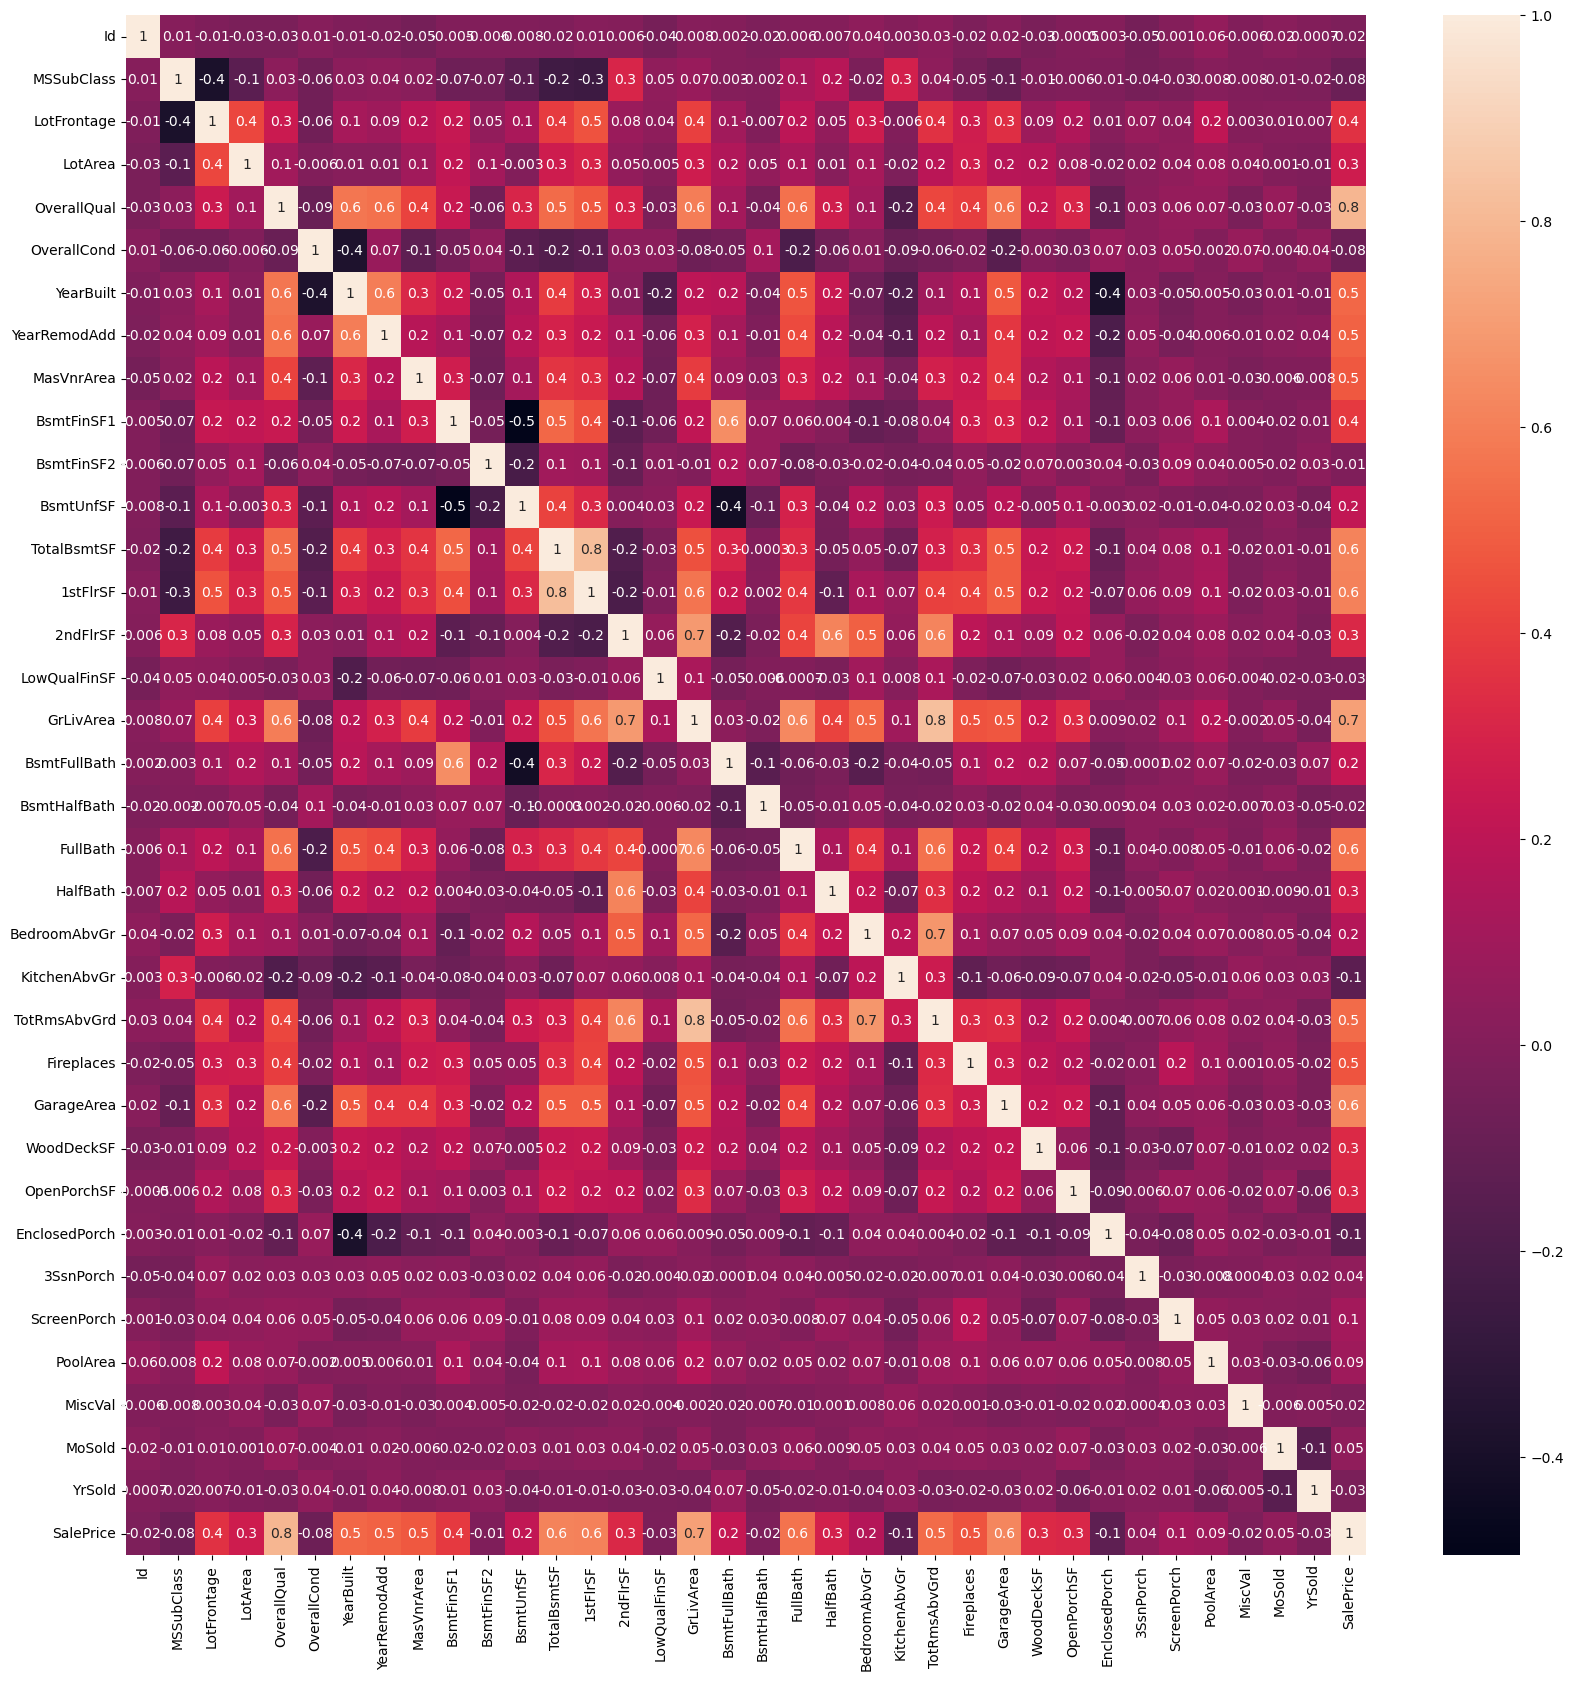

In [8]:
# посмотрим с какими числовыми колонками коррелирует меньше всего
numeric_cols = clean_data.select_dtypes(include=["number"])
plt.figure(figsize=(20, 20))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".1g")
plt.show()

Какова красота, сказка. Теперь надо посмотреть у кого с price самая темная (но не слишком темная, потому что сильная отрицательная корреляция тоже важна), и дропнуть эти колонки

In [9]:
numeric_cols.keys()

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [10]:
numeric_cols.drop(
    [
        "MSSubClass",
        "OverallCond",
        "BsmtFinSF2",
        "LowQualFinSF",
        "BsmtHalfBath",
        "KitchenAbvGr",
        "EnclosedPorch",
        "3SsnPorch",
        "ScreenPorch",
        "PoolArea",
        "MiscVal",
        "MoSold",
        "YrSold",
    ],
    axis=1,
    inplace=True,
)

In [11]:
numeric_cols.shape

(1460, 23)

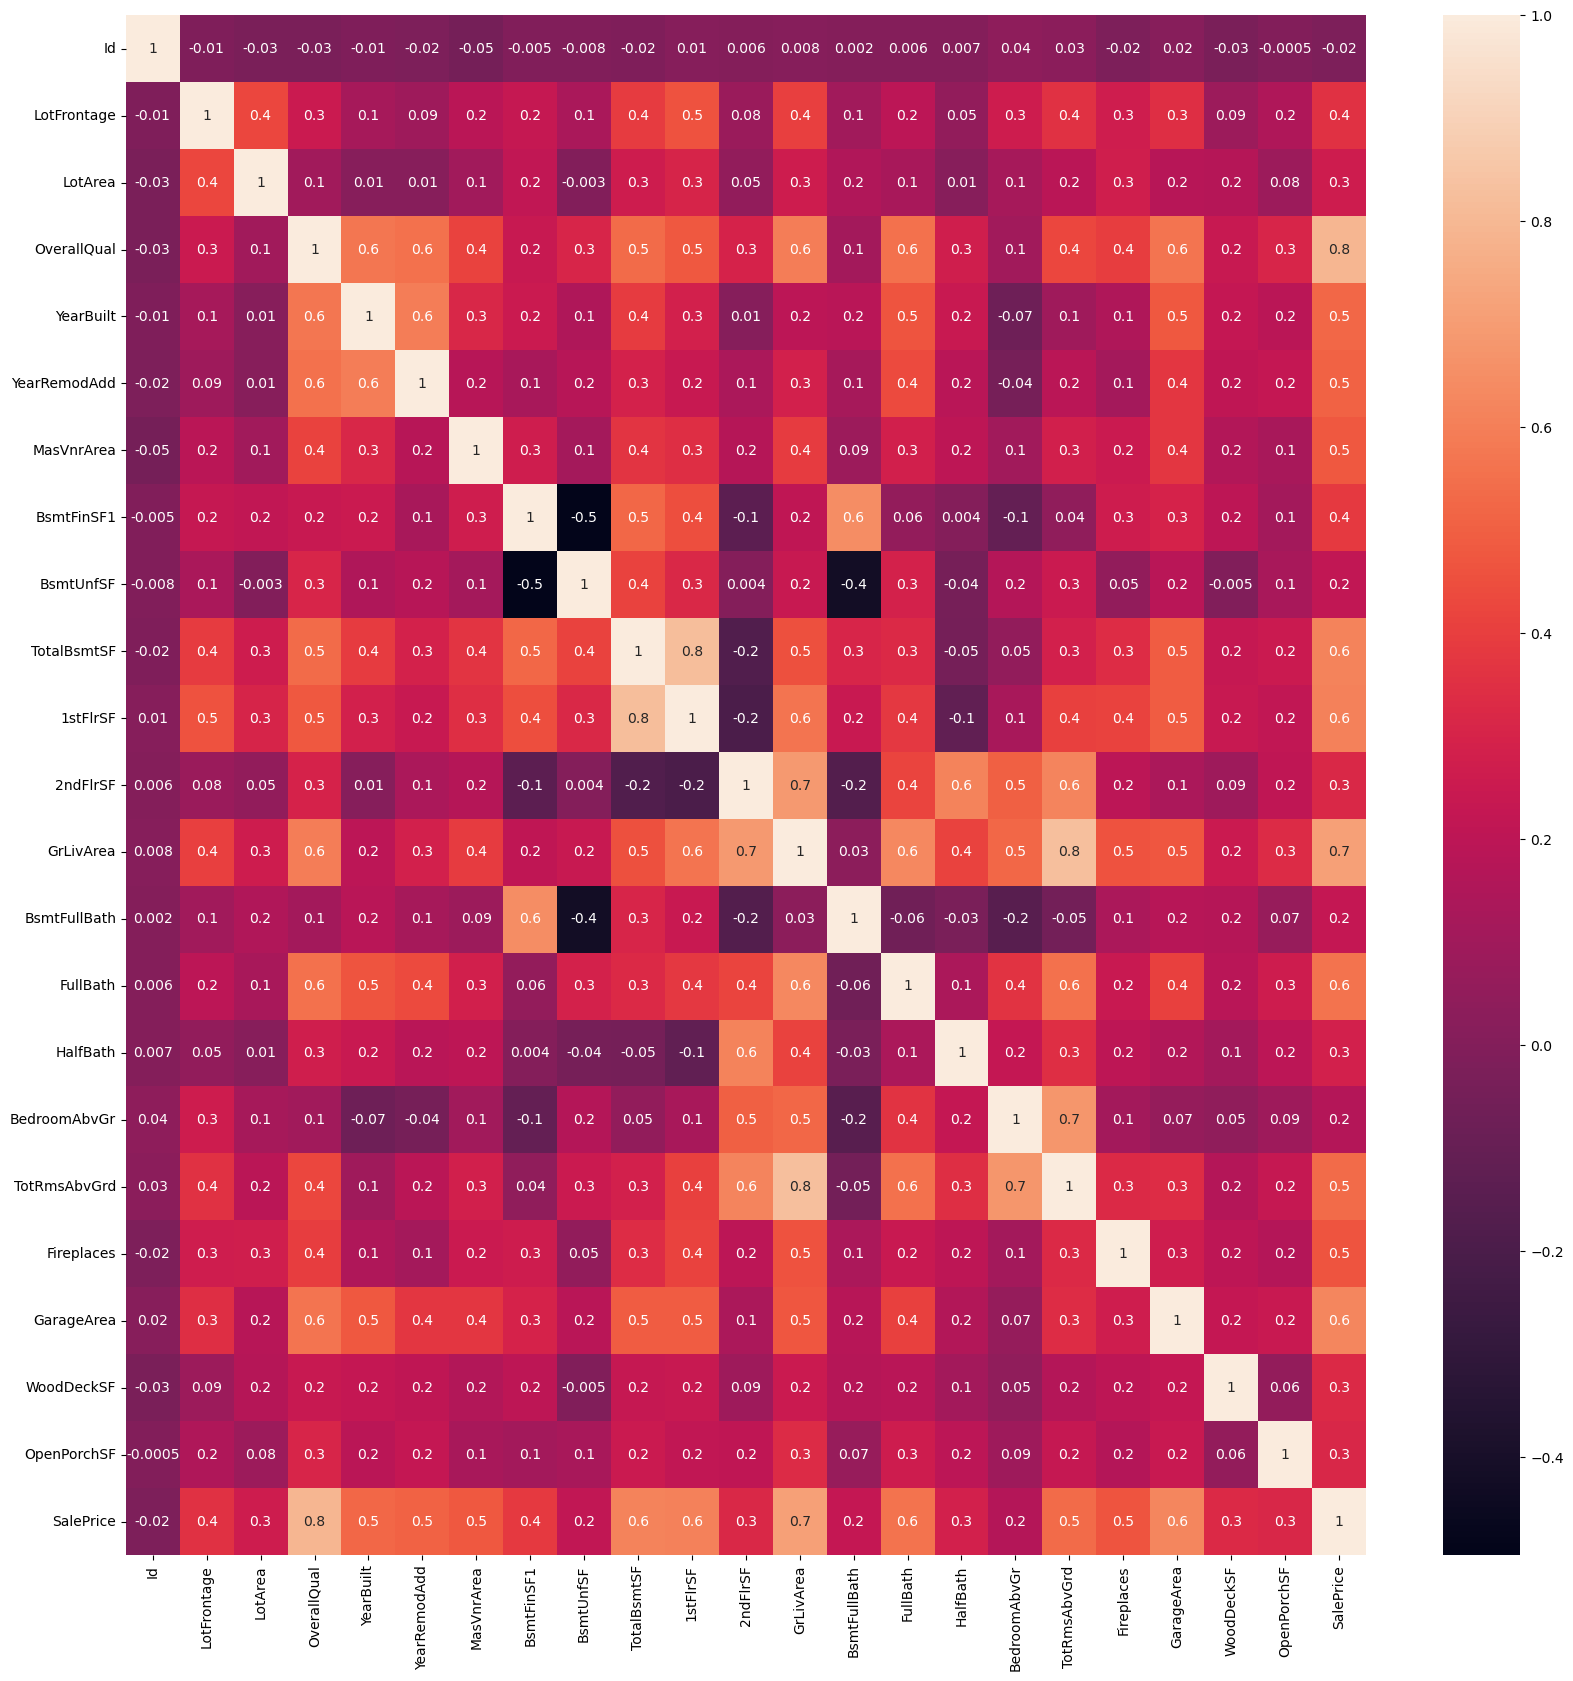

In [12]:
plt.figure(figsize=(20, 20))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".1g")
plt.show()

✅ Есть ли в данных пропуски? Если да, то для каждого столбца, в котором они имеются, посчитайте их количество и их долю от общего числа значений. Что вы наблюдаете?

In [13]:
numeric_cols.isna().sum().sort_values(ascending=False)

LotFrontage     259
MasVnrArea        8
Id                0
BsmtFullBath      0
OpenPorchSF       0
WoodDeckSF        0
GarageArea        0
Fireplaces        0
TotRmsAbvGrd      0
BedroomAbvGr      0
HalfBath          0
FullBath          0
2ndFlrSF          0
GrLivArea         0
1stFlrSF          0
TotalBsmtSF       0
BsmtUnfSF         0
BsmtFinSF1        0
YearRemodAdd      0
YearBuilt         0
OverallQual       0
LotArea           0
SalePrice         0
dtype: int64

✅ Избавьтесь от пропусков. Для каждого из примененных методов обоснуйте свое решение. 

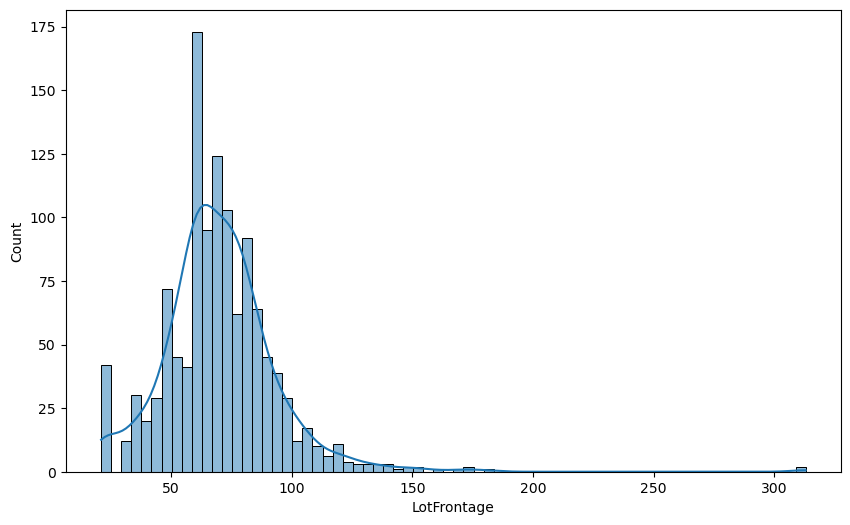

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(numeric_cols["LotFrontage"], bins=70, kde=True)
plt.show()

Я построила график, но не могу понять, на что лучше заменить, на медиану или среднее? Подскажите плиз. Тут сделаю медиану, потому что говорили что она более устойчивая к выбросам

In [15]:
LotFrontage_median = numeric_cols["LotFrontage"].median()
# заполняем пропуски средним в тесте и трейне
numeric_cols["LotFrontage"] = numeric_cols["LotFrontage"].fillna(LotFrontage_median)
numeric_cols.isna().sum().sort_values(ascending=False)

MasVnrArea      8
Id              0
GrLivArea       0
OpenPorchSF     0
WoodDeckSF      0
GarageArea      0
Fireplaces      0
TotRmsAbvGrd    0
BedroomAbvGr    0
HalfBath        0
FullBath        0
BsmtFullBath    0
2ndFlrSF        0
LotFrontage     0
1stFlrSF        0
TotalBsmtSF     0
BsmtUnfSF       0
BsmtFinSF1      0
YearRemodAdd    0
YearBuilt       0
OverallQual     0
LotArea         0
SalePrice       0
dtype: int64

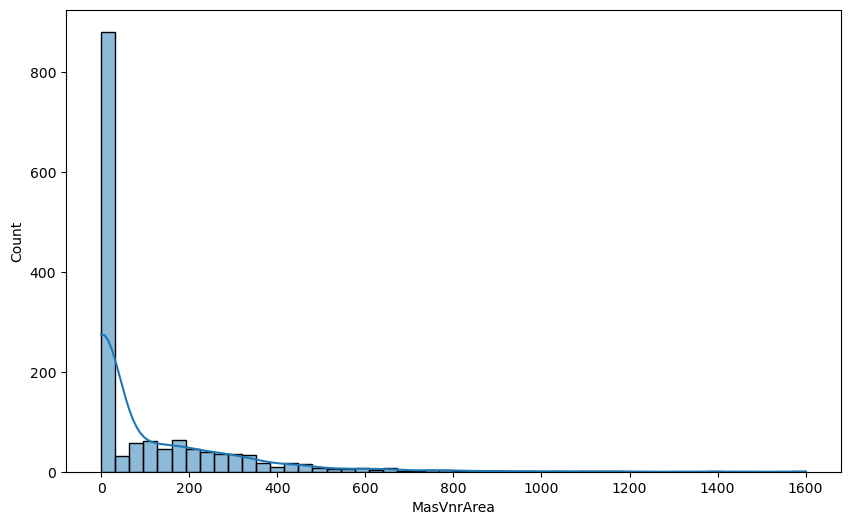

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(numeric_cols["MasVnrArea"], bins=50, kde=True)
plt.show()

In [17]:
# тут заполню средним
MasVnrArea_mean = numeric_cols['MasVnrArea'].mean()
numeric_cols['MasVnrArea'] =numeric_cols['MasVnrArea'].fillna(MasVnrArea_mean)


✅ Проверьте, что вы действительно избавились от пропусков

In [18]:
numeric_cols.isna().sum().sort_values(ascending=False)

Id              0
GrLivArea       0
OpenPorchSF     0
WoodDeckSF      0
GarageArea      0
Fireplaces      0
TotRmsAbvGrd    0
BedroomAbvGr    0
HalfBath        0
FullBath        0
BsmtFullBath    0
2ndFlrSF        0
LotFrontage     0
1stFlrSF        0
TotalBsmtSF     0
BsmtUnfSF       0
BsmtFinSF1      0
MasVnrArea      0
YearRemodAdd    0
YearBuilt       0
OverallQual     0
LotArea         0
SalePrice       0
dtype: int64

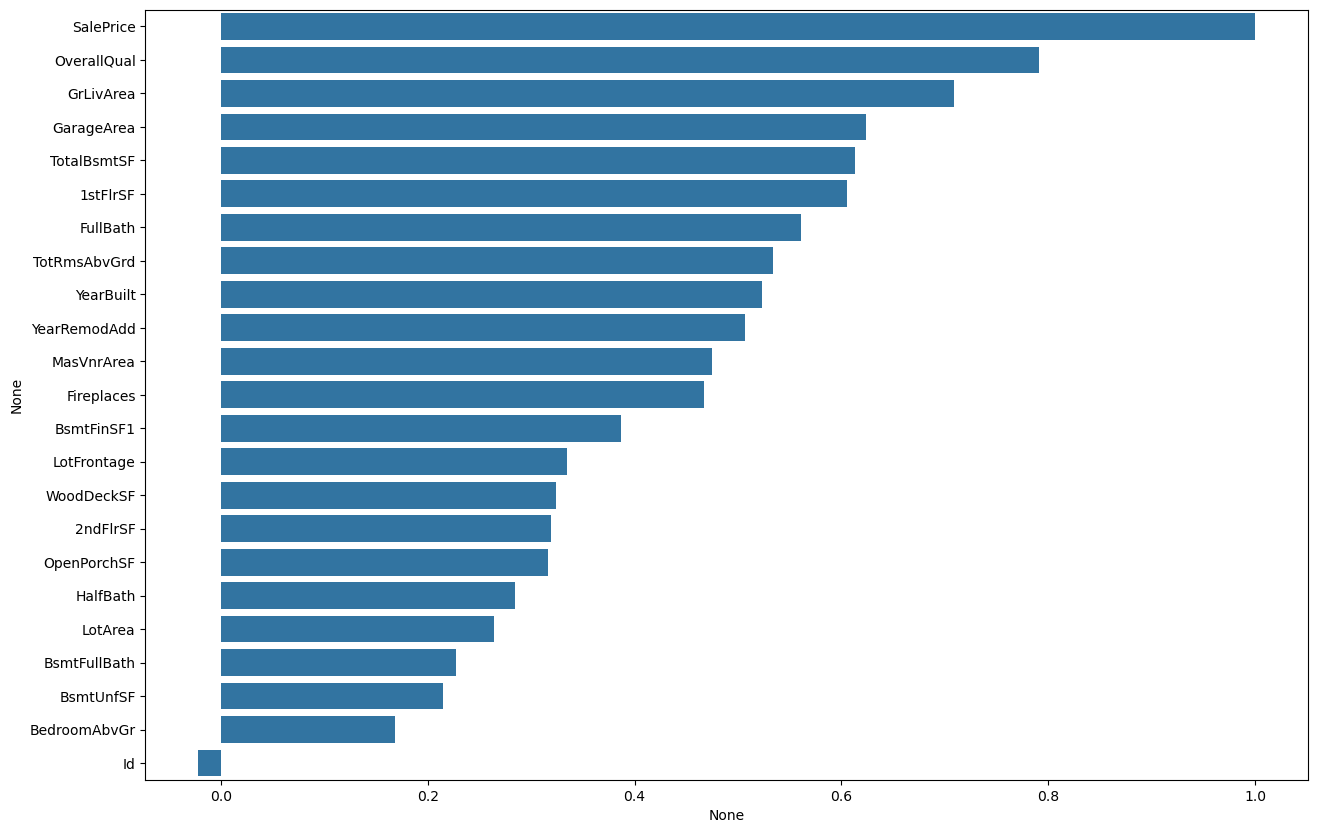

In [19]:

correlations = numeric_cols.corrwith(numeric_cols['SalePrice']).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)
plt.show()

✅ Обработайте категориальные признаки. Объясните выбор метода (one-hot-encoding, label encoding, ...)

In [20]:
clean_data.keys()

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageArea', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'Poo

In [21]:
categoricals = clean_data.drop(columns=numeric_cols) #выводим категориальные
categoricals.drop(   #избавляемся от тех, которых мы дропнули в корреляции. Как еще можно было это сделать?
    [
        "MSSubClass",
        "OverallCond",
        "BsmtFinSF2",
        "LowQualFinSF",
        "BsmtHalfBath",
        "KitchenAbvGr",
        "EnclosedPorch",
        "3SsnPorch",
        "ScreenPorch",
        "PoolArea",
        "MiscVal",
        "MoSold",
        "YrSold",
    ],
    axis=1,
    inplace=True,
)
categoricals.keys()

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

One-hot сильно раздувает пространство признаков, а в Label encoding может потеряться нужная информация, плюс еще не факт, что правильно закодируем. В случае регрессии использовать label encoding сокорее плохая идея

Тут думаю, что все их кодировать нет смысла

In [22]:
one_hot_encoded = pd.get_dummies(categoricals, drop_first=True)
one_hot_encoded.head(4)
one_hot_encoded['SalePrice'] = clean_data['SalePrice']
one_hot_encoded.shape


(1460, 192)

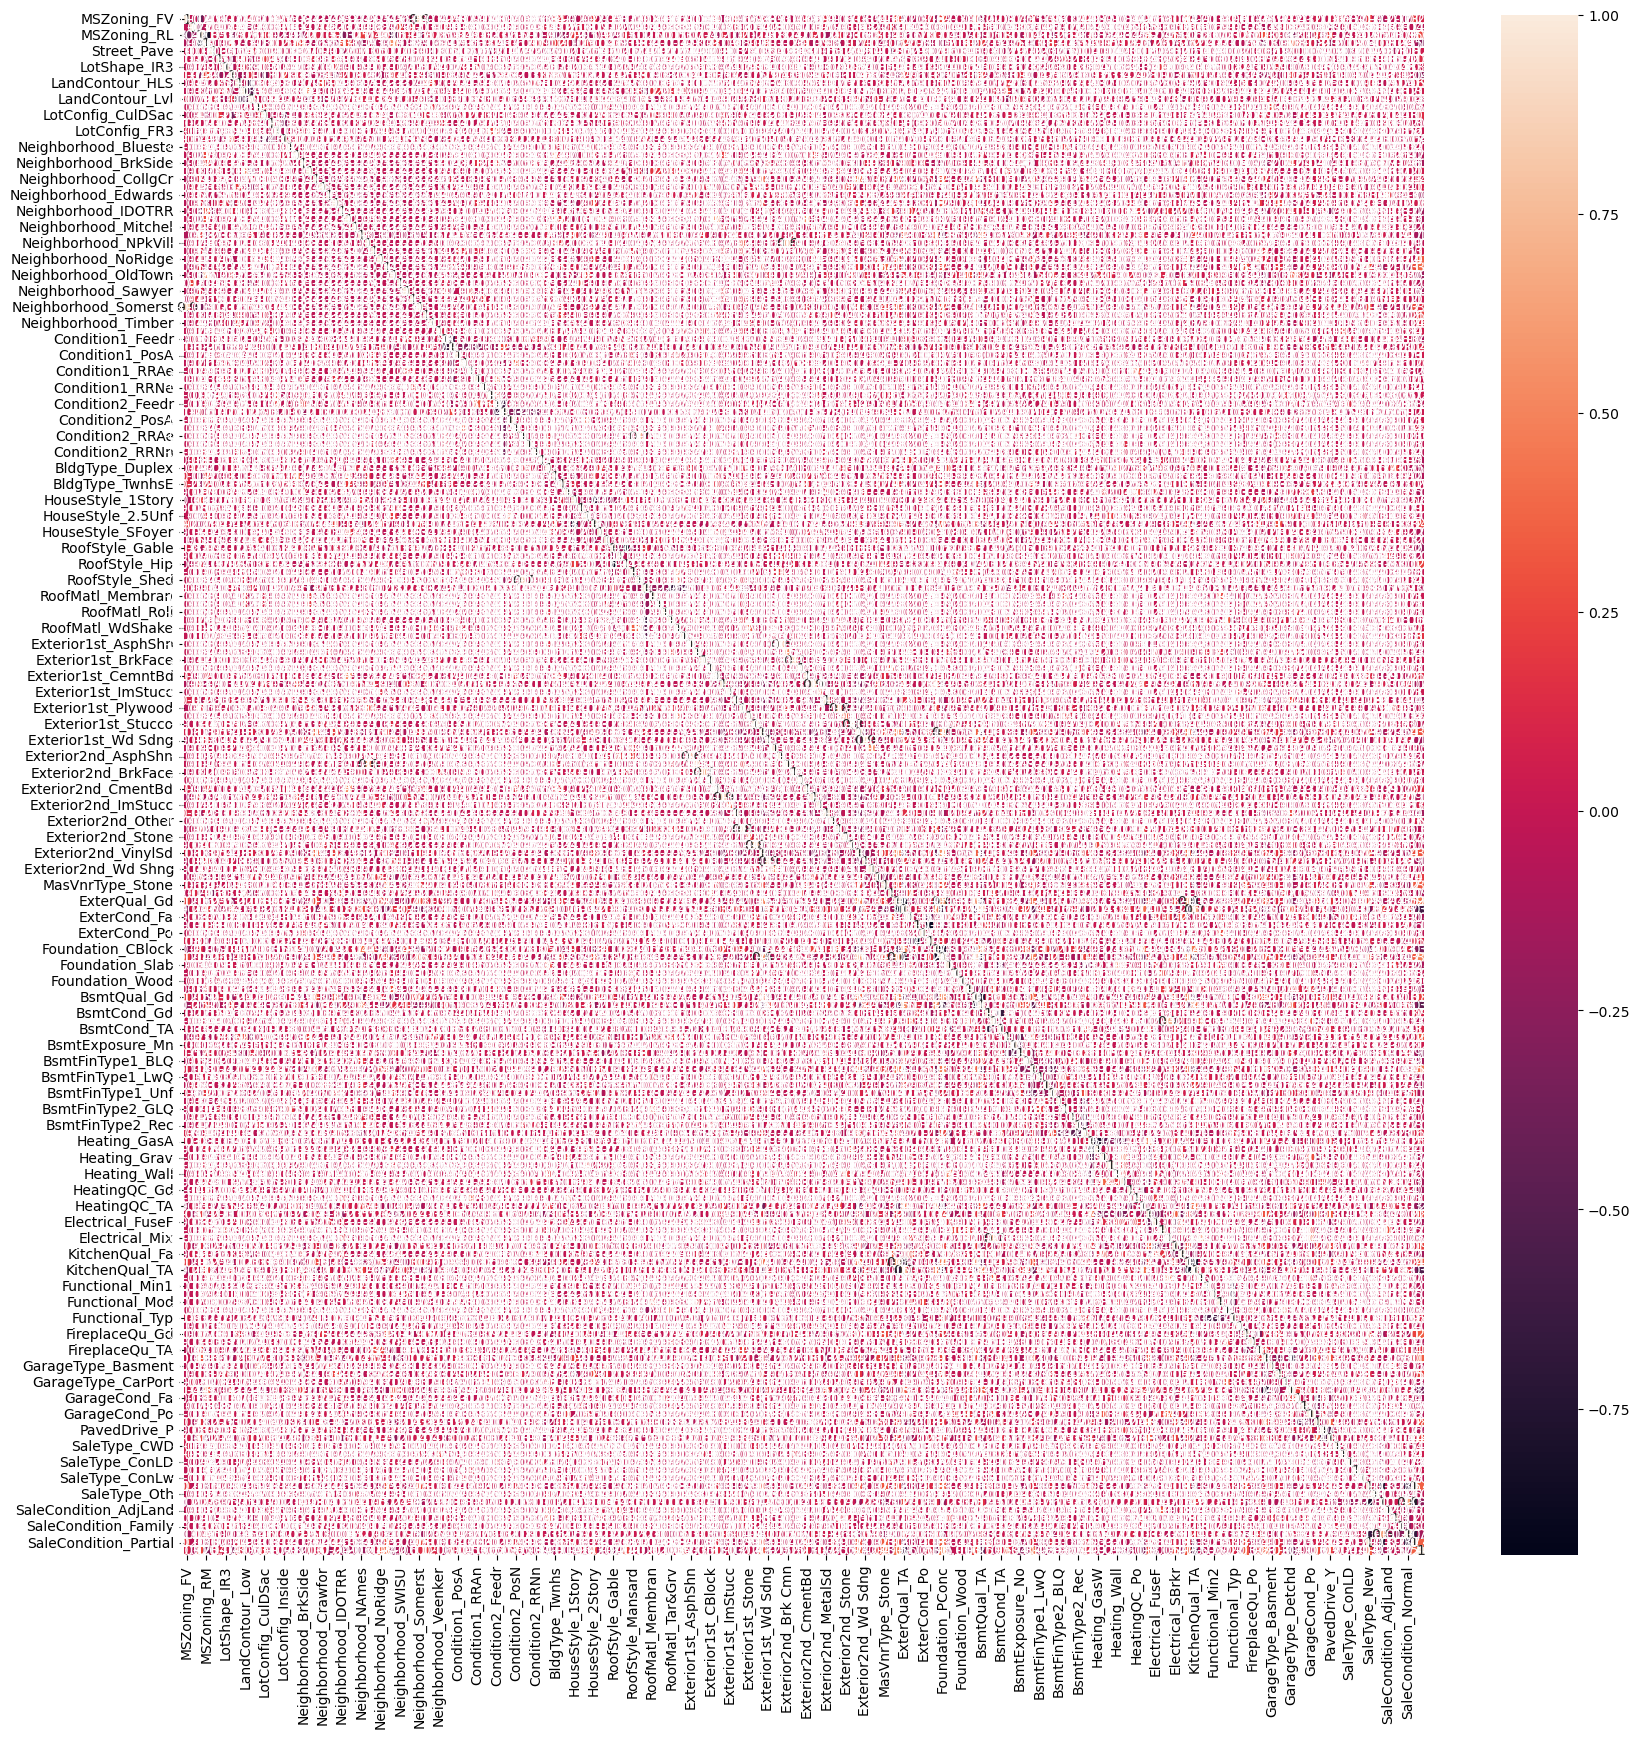

In [23]:
plt.figure(figsize=(20, 20))
sns.heatmap(one_hot_encoded.corr(), annot=True, fmt=".1g")
plt.show()

Это ужас, их оч много, не знаю как посмотреть корреляцию и отсортировать эти признаки, чтобы закодировать только самые важные, поэтому в categoricals возьму только те, которые посчитаю нужным (свое субъективное мнение)

In [24]:
categoricals.keys()

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [25]:
categoricals['SaleCondition'].value_counts()

SaleCondition
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: count, dtype: int64

In [26]:
my_categoricals = categoricals[['ExterCond', 'SaleType', 'SaleCondition']]
my_categoricals.head(3)

ExterCond SaleType SaleCondition
0        TA       WD        Normal
1        TA       WD        Normal
2        TA       WD        Normal

In [27]:
new_hot_encoded = pd.get_dummies(my_categoricals, drop_first=True)
new_hot_encoded.head(4)
new_hot_encoded['SalePrice'] = clean_data['SalePrice']
new_hot_encoded.shape


(1460, 18)

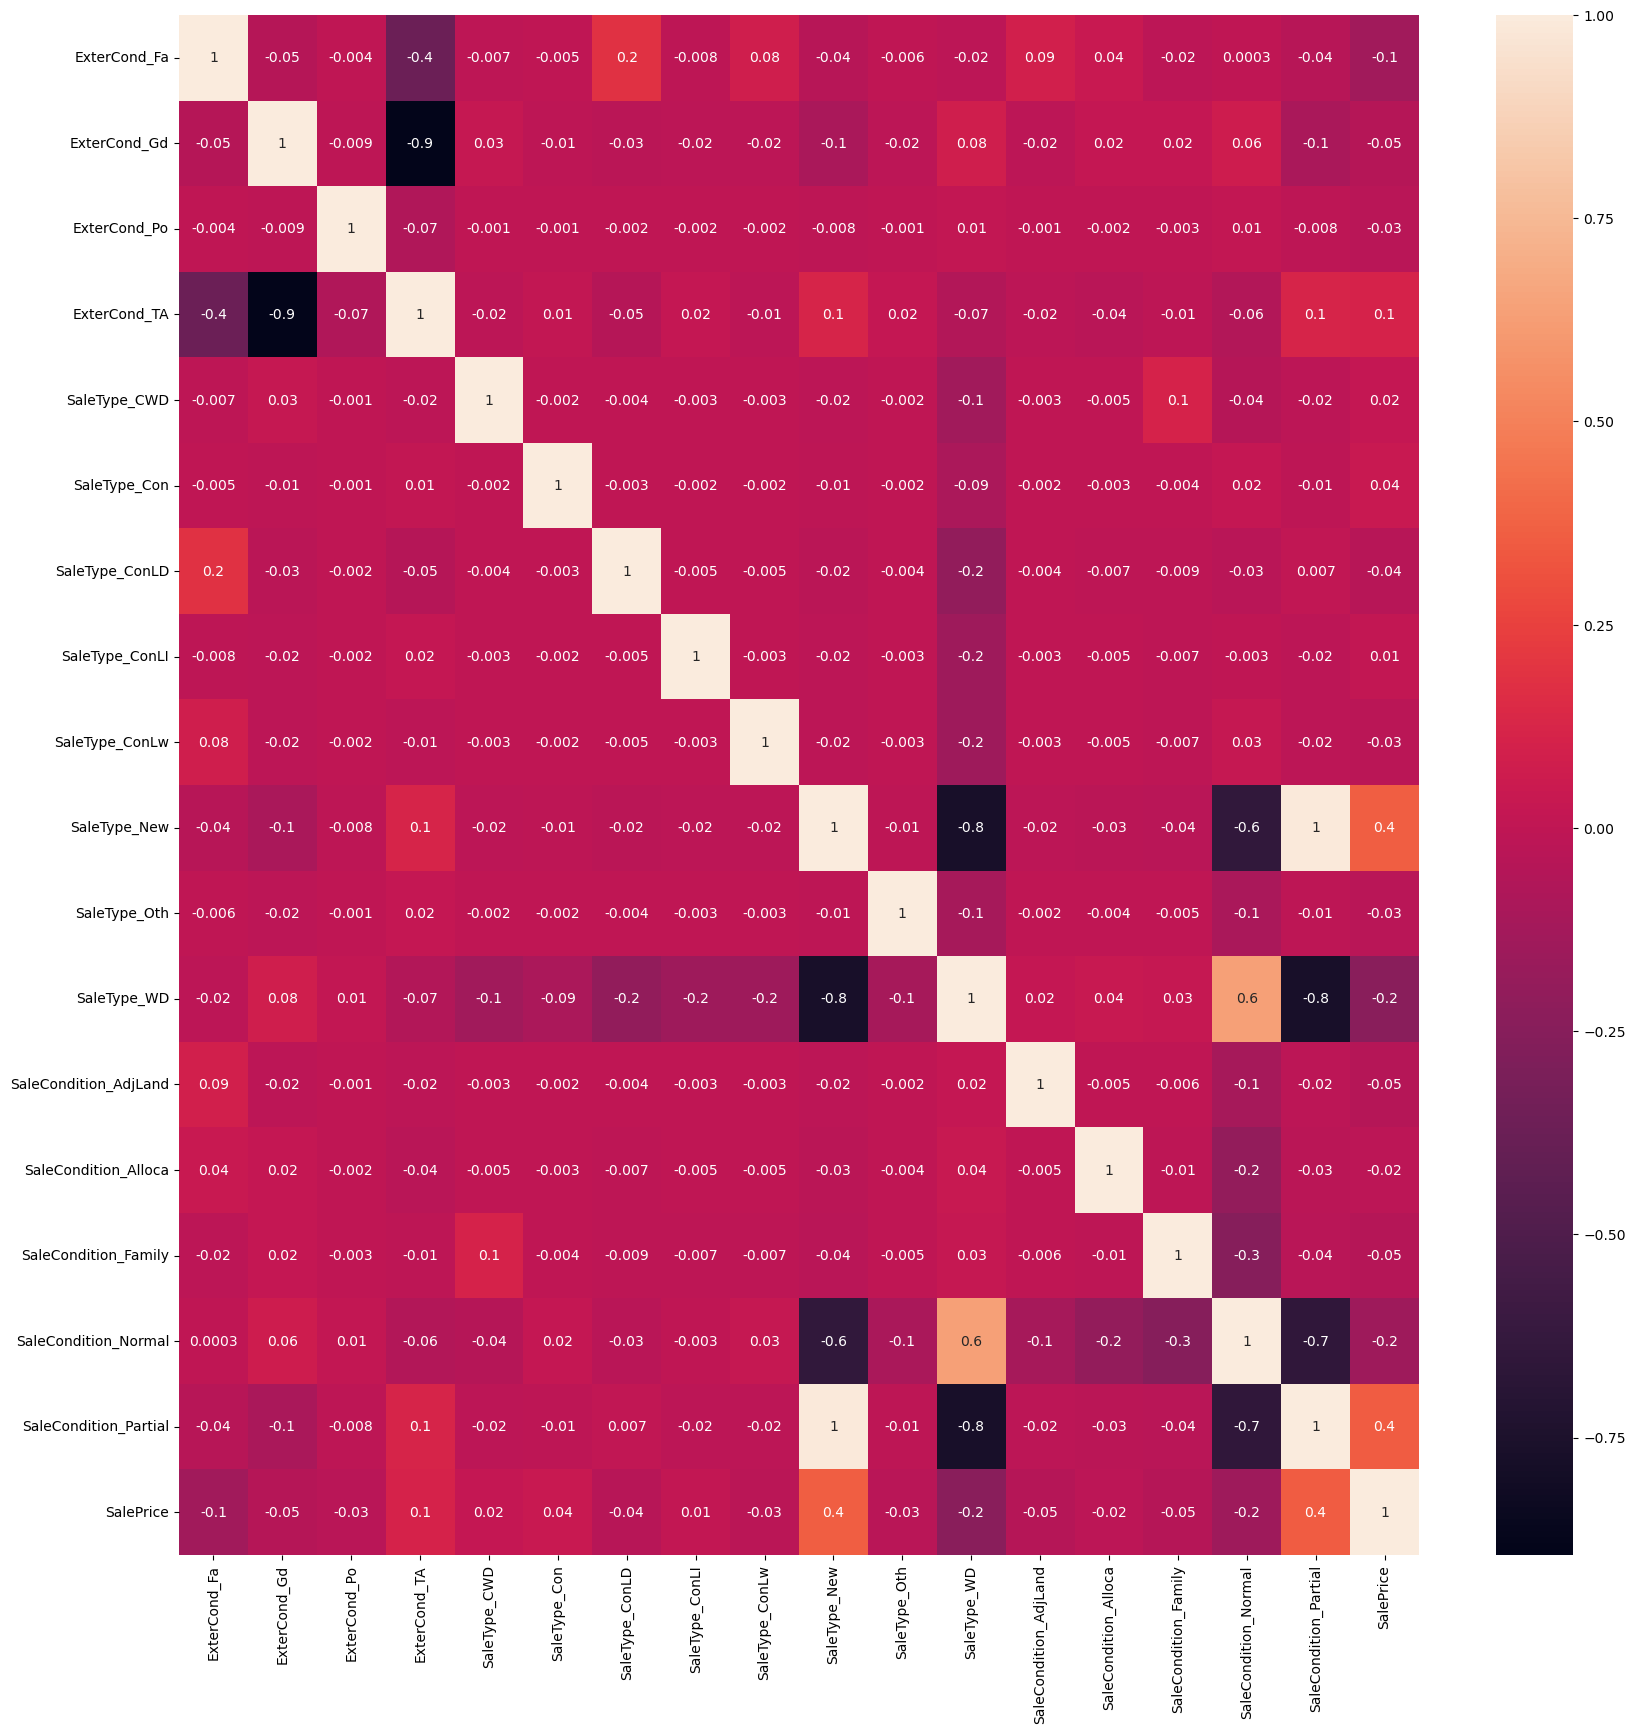

In [28]:
plt.figure(figsize=(20,20))
sns.heatmap(new_hot_encoded.corr(), annot=True, fmt='.1g')
plt.show()

In [29]:
new_hot_encoded.drop(['ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_Oth', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family'], axis=1, inplace=True)
new_hot_encoded.keys()

Index(['ExterCond_TA', 'SaleType_New', 'SaleType_WD', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'SalePrice'],
      dtype='object')

✅ Вычислите и визуализируйте попарную корреляцию Пирсона между всеми признаками. Какие выводы можно сделать?

In [30]:
new_hot_encoded.drop(['SalePrice'], axis=1, inplace=True)
combo =  pd.concat([numeric_cols, new_hot_encoded], axis=1)
combo.shape


(1460, 28)

In [31]:
combo.drop(['Id'], axis=1, inplace=True)

<Axes: >

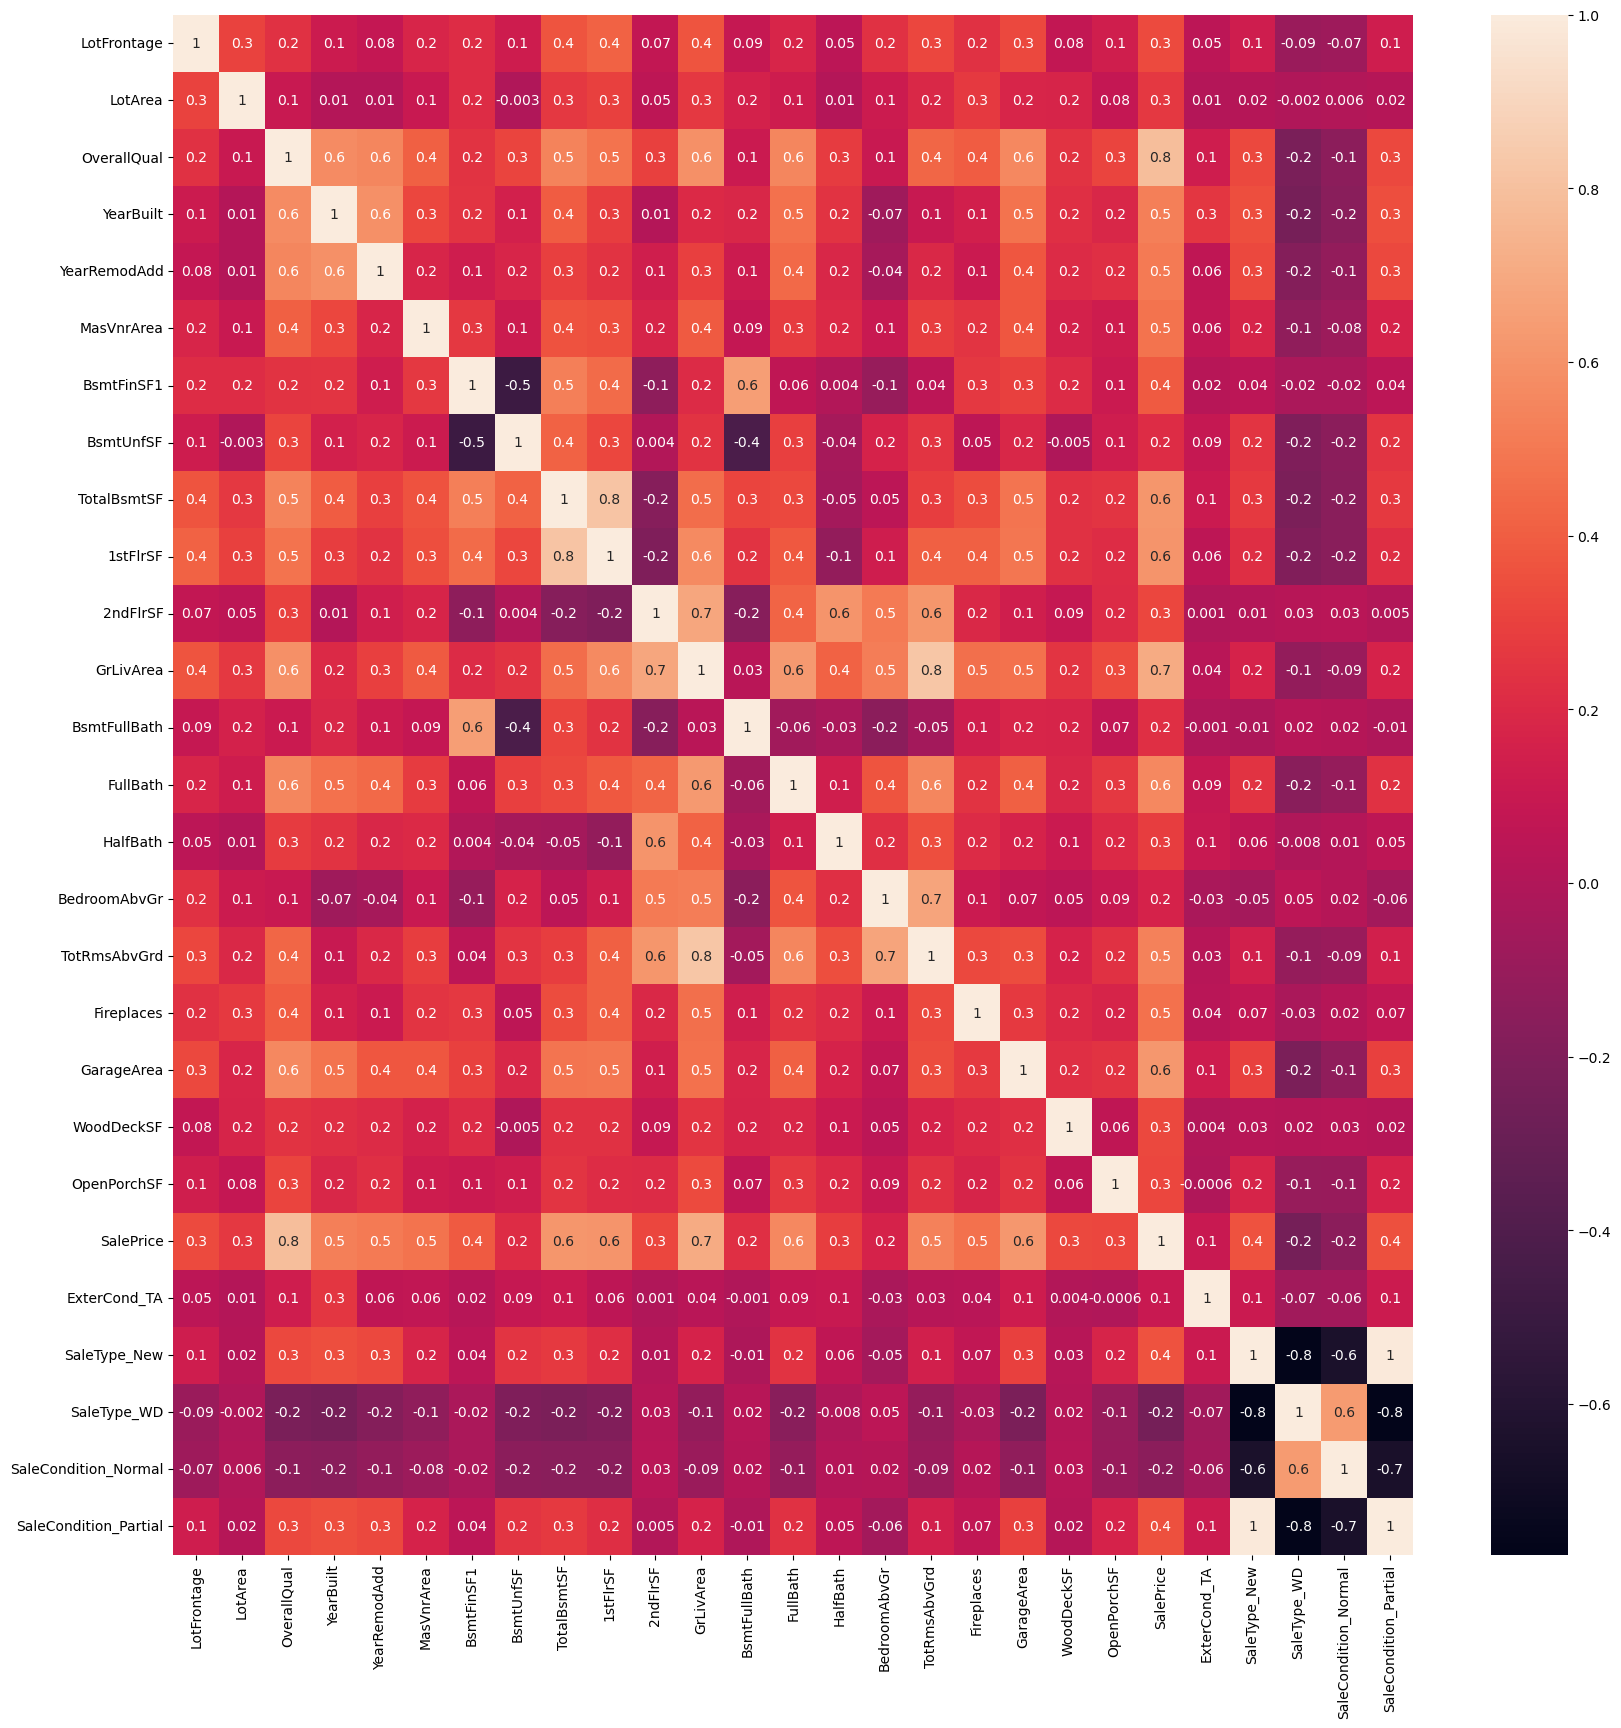

In [32]:
plt.figure(figsize=(20, 20))
sns.heatmap(combo.corr(), annot=True, fmt='.1g')

✅ Найдите признаки с максимальным и минимальным абсолютным значением коэффициента корреляции Пирсона с предсказываемым значением. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

Это OverallQual - max, ExterCond_TA - min (смотрим по модулю)

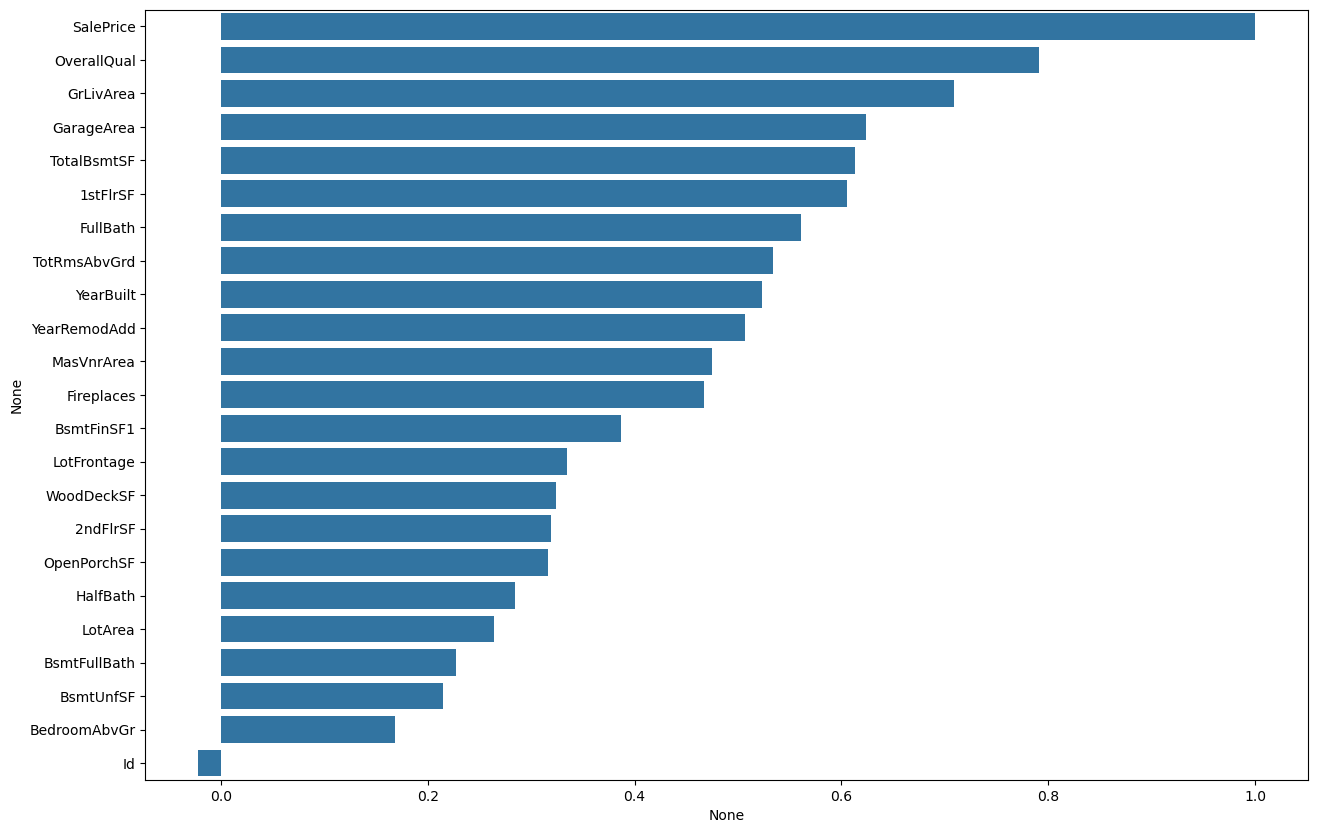

In [33]:
barchart = combo.corrwith(numeric_cols['SalePrice']).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)
plt.show()

✅ Постройте гистограмму распределения предсказываемого значения. Для избавления от разницы в масштабах, а также "смещения" распределения переменной в сторону нормального, можно прологарифмировать ее (это обратимое преобразование, поэтому целевую переменную легко восстановить). 

Подсказка: воспользуйтесь `numpy.log1p`, чтобы сделать преобразование $y \to \ln\left(1 + y\right)$. Постройте гистограмму распределения от нового предсказываемого значения. Опишите наблюдения.

ВАЖНО: далее используйте в качестве предсказываемого значения вектор, который получился после логарифмирования.

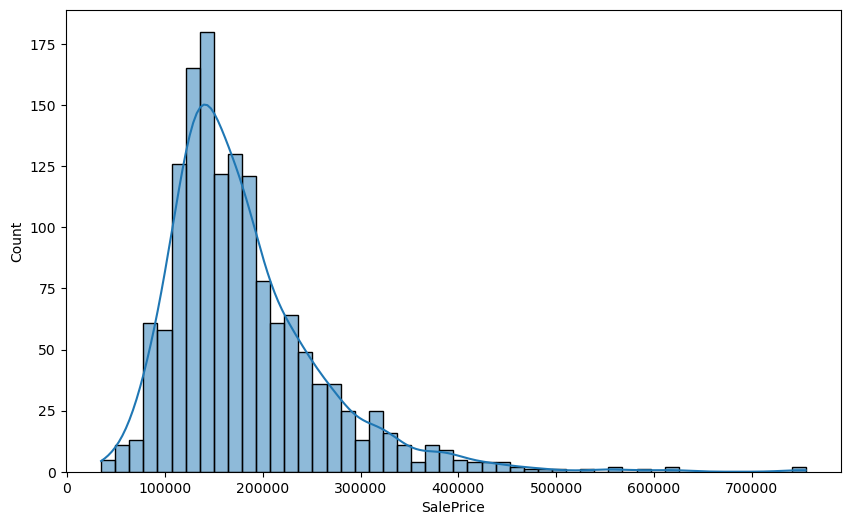

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(combo['SalePrice'], bins=50, kde=True)
plt.show()

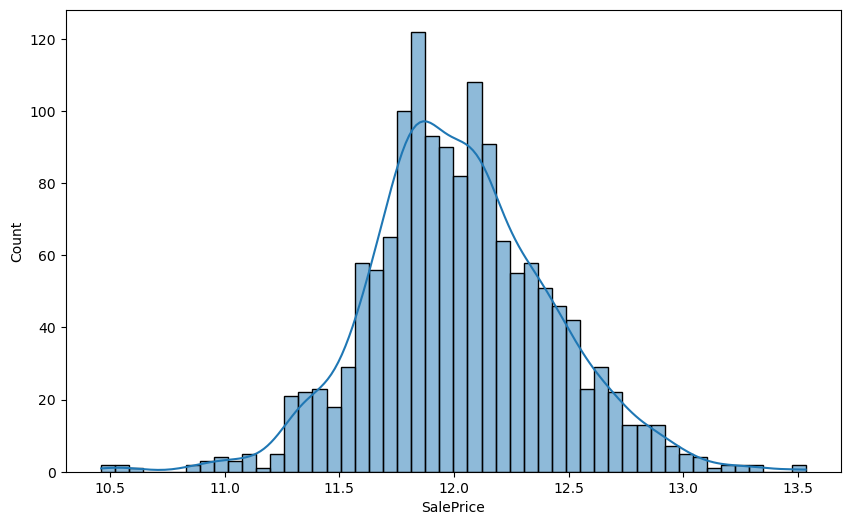

In [35]:
log_price = np.log1p(combo['SalePrice'])
plt.figure(figsize=(10, 6))
sns.histplot(log_price, bins=50, kde=True)
plt.show()

✅ Разбейте выборку на обучающую и тестовую в отношении 75:25. Зафиксируйте при разбиении значение `random_state` = 13. Не забывайте прологорифмировать целевую переменную (как в предыдущем задании)

In [36]:
X = combo.drop('SalePrice',axis=1)
y= log_price

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn import linear_model

from sklearn.linear_model import LassoCV

In [38]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

✅ Примените к данным 

- Линейную регрессию
- Lasso
- Ridge

Для каждого из методов подберите гиперпараметры с помощью кросс-валидации. Обучите алгоритмы с лучшими гиперпараметрами на обучающей выборке и оцените качество по метрикам 
- RMSE 
- MAE
- $R^2$

Опишите полученные результаты.

In [39]:
#сначала отмасштабируем
scaler =StandardScaler()

In [40]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_train)

In [41]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [50]:
from sklearn.model_selection import cross_val_score
# cv - отвечает на сколько фолдов делить
cv_scores = cross_val_score(combo, X_train, y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

InvalidParameterError: The 'estimator' parameter of cross_val_score must be an object implementing 'fit'. Got       LotFrontage  LotArea  OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  \
0            65.0     8450            7       2003          2003       196.0   
1            80.0     9600            6       1976          1976         0.0   
2            68.0    11250            7       2001          2002       162.0   
3            60.0     9550            7       1915          1970         0.0   
4            84.0    14260            8       2000          2000       350.0   
...           ...      ...          ...        ...           ...         ...   
1455         62.0     7917            6       1999          2000         0.0   
1456         85.0    13175            6       1978          1988       119.0   
1457         66.0     9042            7       1941          2006         0.0   
1458         68.0     9717            5       1950          1996         0.0   
1459         75.0     9937            5       1965          1965         0.0   

      BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  Fireplaces  \
0            706        150          856       856  ...           0   
1            978        284         1262      1262  ...           1   
2            486        434          920       920  ...           1   
3            216        540          756       961  ...           1   
4            655        490         1145      1145  ...           1   
...          ...        ...          ...       ...  ...         ...   
1455           0        953          953       953  ...           1   
1456         790        589         1542      2073  ...           2   
1457         275        877         1152      1188  ...           2   
1458          49          0         1078      1078  ...           0   
1459         830        136         1256      1256  ...           0   

      GarageArea  WoodDeckSF  OpenPorchSF  SalePrice  ExterCond_TA  \
0            548           0           61     208500          True   
1            460         298            0     181500          True   
2            608           0           42     223500          True   
3            642           0           35     140000          True   
4            836         192           84     250000          True   
...          ...         ...          ...        ...           ...   
1455         460           0           40     175000          True   
1456         500         349            0     210000          True   
1457         252           0           60     266500         False   
1458         240         366            0     142125          True   
1459         276         736           68     147500          True   

      SaleType_New  SaleType_WD  SaleCondition_Normal  SaleCondition_Partial  
0            False         True                  True                  False  
1            False         True                  True                  False  
2            False         True                  True                  False  
3            False         True                 False                  False  
4            False         True                  True                  False  
...            ...          ...                   ...                    ...  
1455         False         True                  True                  False  
1456         False         True                  True                  False  
1457         False         True                  True                  False  
1458         False         True                  True                  False  
1459         False         True                  True                  False  

[1460 rows x 27 columns] instead.

In [42]:
print('MSE train:', mean_squared_error(y_train, lin_reg.predict(X_train)))
print('MSE test:', mean_squared_error(y_test, lin_reg.predict(X_test)))

MSE train: 0.016436844445240142


ValueError: Found input variables with inconsistent numbers of samples: [365, 1095]

## Не знаю в чем проблема, помогите плиз. Подозреваю, что возможно связано с логарифмированием, но я ведь изначально во весь y запихала отлогарифмированную цену

$F - > n^2$

In [ ]:
lasso =linear_model.Lasso(alpha=10)
lasso.fit(X_train, y_train)

Lasso(alpha=10)

In [ ]:
print('mse train lasso', mean_squared_error(y_train, lasso.predict(X_train)))
print('mse test lasso', mean_squared_error(y_test, lasso.predict(X_test)))

mse train lasso 0.15744412439308852


ValueError: Found input variables with inconsistent numbers of samples: [365, 1095]

In [ ]:
ridge=linear_model.Ridge(alpha=10)
ridge.fit(X_train, y_train)

Ridge(alpha=10)

In [54]:
len(y_test)

365

In [55]:
len(X_test)

1095

In [ ]:
print('mse train ridge', mean_squared_error(y_train, ridge.predict(X_train)))
print('mse test ridge', mean_squared_error(y_test, ridge.predict(X_test)))

mse train ridge 0.016523701472811594


ValueError: Found input variables with inconsistent numbers of samples: [365, 1095]

In [53]:
combo.dtypes

LotFrontage              float64
LotArea                    int64
OverallQual                int64
YearBuilt                  int64
YearRemodAdd               int64
MasVnrArea               float64
BsmtFinSF1                 int64
BsmtUnfSF                  int64
TotalBsmtSF                int64
1stFlrSF                   int64
2ndFlrSF                   int64
GrLivArea                  int64
BsmtFullBath               int64
FullBath                   int64
HalfBath                   int64
BedroomAbvGr               int64
TotRmsAbvGrd               int64
Fireplaces                 int64
GarageArea                 int64
WoodDeckSF                 int64
OpenPorchSF                int64
SalePrice                  int64
ExterCond_TA                bool
SaleType_New                bool
SaleType_WD                 bool
SaleCondition_Normal        bool
SaleCondition_Partial       bool
dtype: object

✅ Постройте гистограммы значений весов для линейной регрессии, Lasso и Ridge. Опишите наблюдения, проанализируйте результаты.

К сожалению не смогла построить, потому что не знаю что за ошибка сверху (((

Извиняюсь если у вас jupyter тоже завис на минуту, рисуя one-hot catastrophy


Итого вопросы по домашке:
* какое значение для корреляции пороговое, чтобы дропать столбцы?
* как по графику понять, на что лучше заменять: на медиану или среднее? Или лучше всегда на медиану, потому что она устойчива к выбросам всяким и смещениям?  **Среднеее если норм распределение и нет выбросов**
* можно ли было как-то по другому, по более умному сделать даафрейм categoricals? А не дважны дропать столбиики персекающиеся?
* можно ли как то понять, какие категориальные признаки стоит кодироать? Потому что страшно когда рисуется таблица 1000*10000 и сложно читать корреляционные значения
* самое важное - что за ошибка в последней части? Из-за нее не смогла дальше делать блин. Я нашла инфу, что это может быть из-за разной блины y_test и x_test, она рили разная, но что делать? Запуталась, помогите пожалуйста 🌷